In [14]:
%matplotlib inline

In [15]:
# 코딩에 필요한 도구 소환
import torch
from torch import nn, optim, tensor
from torch.utils.data import DataLoader, Dataset,TensorDataset, random_split
import torch.nn.functional as F

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, mean_squared_error

from google.colab import files

In [16]:
#디바이스 세팅
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
# 옵션 데이터 업로드
files.upload()

Saving SNP.csv to SNP (1).csv


{'SNP.csv': b'Stock Price,Strike Price,Maturity,Dividends,Volatility,Risk-free,Call Price\r\n220.04,202.5,0.0035875034856896596,0.018500000000000003,0.2611,0.0088,18.9\r\n220.04,205.0,0.0035875034856896596,0.018500000000000003,0.2611,0.0088,15.7\r\n220.04,207.5,0.0035875034856896596,0.018500000000000003,0.2611,0.0088,13.3\r\n220.04,210.0,0.0035875034856896596,0.018500000000000003,0.2611,0.0088,10.7\r\n220.04,212.5,0.0035875034856896596,0.018500000000000003,0.2611,0.0088,8.3\r\n220.04,215.0,0.0035875034856896596,0.018500000000000003,0.2611,0.0088,6.0\r\n220.04,217.5,0.0035875034856896596,0.018500000000000003,0.2611,0.0088,4.0\r\n220.04,220.0,0.0035875034856896596,0.018500000000000003,0.2611,0.0088,2.45\r\n220.04,222.5,0.0035875034856896596,0.018500000000000003,0.2611,0.0088,1.25\r\n220.04,225.0,0.0035875034856896596,0.018500000000000003,0.2611,0.0088,0.6\r\n220.04,227.5,0.0035875034856896596,0.018500000000000003,0.2611,0.0088,0.45\r\n220.04,230.0,0.0035875034856896596,0.0185000000000000

In [379]:
# 옵션 데이터 읽기
option_data = pd.read_csv("/content/SNP.csv")

In [380]:
# 정규화
option_data["Stock Price"] = option_data["Stock Price"]/option_data["Strike Price"]
option_data["Call Price"] = option_data["Call Price"]/option_data["Strike Price"]
option_data["Strike Price"] = option_data["Strike Price"]/option_data["Strike Price"]
option_data.head()

,Stock Price,Strike Price,Maturity,Dividends,Volatility,Risk-free,Call Price
0,1.086617,1.0,0.003588,0.0185,0.2611,0.0088,0.093333
1,1.073366,1.0,0.003588,0.0185,0.2611,0.0088,0.076585
2,1.060434,1.0,0.003588,0.0185,0.2611,0.0088,0.064096
3,1.047810,1.0,0.003588,0.0185,0.2611,0.0088,0.050952
4,1.035482,1.0,0.003588,0.0185,0.2611,0.0088,0.039059


In [381]:
X = option_data.drop('Call Price', axis=1).to_numpy()         # Label 제외 -> Input 값
Y = option_data['Call Price'].to_numpy().reshape((-1,1))     # Label 값

In [382]:
# Tensor
class TensorData(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index] 

    def __len__(self):
        return self.len

In [383]:
#고정값
input_size = 6              # 인풋 크기
hidden_size = 100       # 히든 레이어 크기
output_size = 1            # 아웃풋 크기

# 하이퍼파라미터 설정
learning_rate = 0.00007         # 학습률
num_epoch = 100                  # 에포크 수
batch_size = 512                    # 배치 사이즈
weight_decay = 0.00001       # decay 값
KFold_SPLITS = 10                  # KFold Split 수
set_shuffle = True                   # 데이터 셔플 
dropout_rate = 0.2                # 드롭아웃률

In [384]:
# MLP 모델; FFNN 모델
class MLP(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(6, 100)
    self.fc2 = nn.Linear(100, 100)
    self.fc3 = nn.Linear(100, 100)
    self.fc4 = nn.Linear(100, 100)
    self.fc5 = nn.Linear(100, 100)
    self.fc6 = nn.Linear(100, 1)
    self.dropout = nn.Dropout(dropout_rate)
  
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.dropout(F.elu(self.fc2(x)))
    x = self.dropout(F.rrelu(self.fc3(x)))
    x = self.dropout(F.relu(self.fc4(x)))
    x = self.dropout(F.rrelu(self.fc5(x)))
    x = F.elu(self.fc6(x))

    return x

In [385]:
### K-Fold로 진행
kf = KFold(n_splits = KFold_SPLITS)
n_iter = 0

In [386]:
# Model, Loss Function, Optimizer 소환
model = MLP(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [387]:
# 모델 검증 함수
def evaluation(dataloader):

  predictions = torch.tensor([], dtype=torch.float) # 예측값 텐서
  actual = torch.tensor([], dtype=torch.float) # 실제값 텐서
  size = len(dataloader.dataset)                    # 크기
  num_batches = len(dataloader)                 # 미니배치 개수
  test_loss, correct = 0, 0                              # 테스트 오류, 정확도
  with torch.no_grad():
    model.eval()        # 평가할 때 eval() 사용

    for data in dataloader:
      inputs, values = data                                             # inputs, values(labels)
      predicts = model(inputs)                                        # 예측 모델 생성
      test_loss += criterion(predicts, values).item()       # test loss 누적
      predictions = torch.cat((predictions, predicts), 0) # 예측값 누적
      actual = torch.cat((actual, values), 0)                   # 실제값 누적

  test_loss /= num_batches        # test loss 계산
  accuracy = 100-(100*test_loss/torch.mean(actual))
  print(f"Accuracy : {accuracy:>0.1f}%, Avg loss : {test_loss:>8f} \n")
  predictions = predictions.numpy() # 예측값 넘파이 배열
  actual = actual.numpy() # 실젯값 넘파이 배열
  rmse = np.sqrt(mean_squared_error(predictions, actual)) # RMSE 계산

  return rmse, predictions, actual, accuracy

In [388]:
loss_ = [] # loss 리스트
n = 0  # trainloader length
accuracy_list = []    # accuracy 리스트
for train_idx, test_idx in kf.split(X, Y):
  n_iter += 1
  print(f'--------------------{n_iter}번째 KFold-------------------')
  print(f'train_idx_len : {len(train_idx)} / test_idx_len : {len(test_idx)}')
  X_train, X_test = X[train_idx, :], X[test_idx, :]
  Y_train, Y_test = Y[train_idx,:], Y[test_idx,:]
  # 학습 데이터, 시험 데이터 배치 형태로 구축하기
  trainsets = TensorData(X_train, Y_train)
  trainloader = torch.utils.data.DataLoader(trainsets, batch_size=batch_size, shuffle=set_shuffle)
  n = len(trainloader)
  testsets = TensorData(X_test, Y_test)
  testloader = torch.utils.data.DataLoader(testsets, batch_size=batch_size, shuffle=set_shuffle)
  for epoch in range(num_epoch):

    running_loss = 0.0 # Batch Loss

    for i, data in enumerate(trainloader, 0): # Batch
      
      inputs, values = data # X, Y = Data

      optimizer.zero_grad() # Optimizer 초기화

      outputs = model(inputs)             # 예측값 산출
      loss = criterion(outputs, values) # Loss 계산
      loss.backward()                          # 역전파
      optimizer.step()                            # 가중치 업데이트

      running_loss += loss.item()          # Epoch 평균 Loss를 구하기 위해 더하기
    print(f'epoch[{epoch+1}/{num_epoch}]', f'Loss : {running_loss}')
    loss_.append(running_loss/n) # MSE(Mean Squared Error) 계산
  test_rmse, test_predictions, test_values, accuracy = evaluation(testloader)
  accuracy_list.append(accuracy)
print("Final Model's Average Accuracy is", np.mean(accuracy_list), "%")

--------------------1번째 KFold-------------------
train_idx_len : 5335 / test_idx_len : 593
epoch[1/100] Loss : 1.8659260272979736
epoch[2/100] Loss : 1.7255389615893364
epoch[3/100] Loss : 1.6459532380104065
epoch[4/100] Loss : 1.457583226263523
epoch[5/100] Loss : 1.360839158296585
epoch[6/100] Loss : 1.2066127881407738
epoch[7/100] Loss : 1.1245974898338318
epoch[8/100] Loss : 1.048507571220398
epoch[9/100] Loss : 0.9806667268276215
epoch[10/100] Loss : 0.9239811971783638
epoch[11/100] Loss : 0.9347604848444462
epoch[12/100] Loss : 0.8884911499917507
epoch[13/100] Loss : 0.8376138731837273
epoch[14/100] Loss : 0.759335994720459
epoch[15/100] Loss : 0.6933534927666187
epoch[16/100] Loss : 0.6319951862096786
epoch[17/100] Loss : 0.516207929700613
epoch[18/100] Loss : 0.42751846089959145
epoch[19/100] Loss : 0.31401065923273563
epoch[20/100] Loss : 0.22135854419320822
epoch[21/100] Loss : 0.16452700924128294
epoch[22/100] Loss : 0.12437855172902346
epoch[23/100] Loss : 0.111563754267990

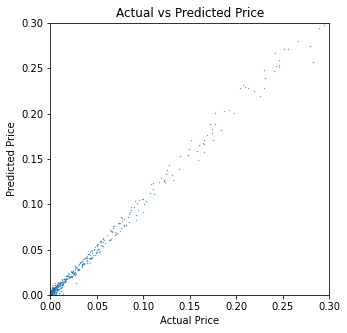

In [389]:
plt.figure(figsize=(5, 5))
plt.scatter(test_values, test_predictions, s= 0.1)

plt.ylabel("Predicted Price")
plt.xlabel("Actual Price")
plt.xlim([0, 0.3])
plt.ylim([0, 0.3])

plt.title("Actual vs Predicted Price")
plt.show()